In [1]:
import numpy as np
import pandas as pd
# from sqlalchemy import types, create_engine
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, HTML
from ipywidgets import Layout, interact, IntSlider, widgets


In [2]:
#Random data set with a sensative attribue of food choise
data = {'Name (ID)' : ['Bill','Julia','Rose','Gwen','Peter','James','Anita','Rob',
                  'Jess','Edith','Catherin','Ellie','Andrew','Ruth','Barry','Hope',
                  'Ruby','Sian','Edward','James','Amanda'],
        'Age (QID)' : [23,19,22,25,30,18,18,16,28,29,21,
                  25,18,27,19,13,25,19,18,19,23], 
        'Gender (QID)' : ['M','F','F','F','M','M','F','M','F','M','M','F','M','F',
                'F','M','F','F','M','F','M'],
        'Political Party' : ['Green Party','Red Party','Red Party','Green Party','Green Party',
                'Red Party','Red Party','Green Party','Red Party','Green Party',
                'Green Party','Green Party','Green Party','Red Party','Green Party',
                'Red Party','Green Party','Red Party','Red Party','Red Party',
                'Green Party']}
                  
df = pd.DataFrame(data=data)

df['Name (ID)'] = '*'


## Metrics functions

In [3]:
def k_annonymity(df, qid):
    """returns the k annonymity value given the quasi-identifier field titles
    
    Parameters
    ----------
    df : DataFrame
        dataframe for which k value is to be calculated
    qid : list
        list of quasi-identifier columns
        
    Returns
    -------
    int 
        k value 
    """

    quid_groupsize = df.groupby(qid).size()
    return quid_groupsize[quid_groupsize > 0].min()


def l_diversity(df, qid, sa):
    """returns the l diversity value given the quasi-identifier field titles
    
    Parameters
    ----------
    df : DataFrame
        dataframe for which k value is to be calculated
    qid : list
        list of quasi-identifier columns
    sa : list
        list of sensitive attribute columns
        
    Returns
    -------
    int 
        l value 
    """
    sa_size_quids = df.groupby(qid)[sa].nunique()
    return sa_size_quids[sa_size_quids > 0].squeeze().min() # This assumes only one SA!
    # l-divesity generally only applies to a single SA 
    
def GIL(uq, lq, u, l):
    return (uq - lq) / (u - l)
    

# Combined

In [4]:
k = widgets.IntSlider(value=1, min=1, max=5, layout=Layout(width='400px'))
step_size = widgets.IntSlider(value=1, min=1, max=40,layout=Layout(width='400px'))

dfs = df.copy()

def meassure_supression(k, step_size):
    QID = ['Age (QID)', 'Gender (QID)'] # define quasi-identifyer groups
    
    dfs = df.copy()
    dfs['ranged'] = np.floor((dfs['Age (QID)']/step_size))*step_size
    dfs['ranged'] = dfs['ranged'].astype(int)
    dfs['Age (QID)'] = dfs['ranged'].astype(str) + '-' + (dfs['ranged']+step_size).astype(str)
    dfs = dfs.drop(columns=['ranged'])

    orig_length = len(df)
    new_length = len(dfs.groupby(QID).filter(lambda x: len(x)>=k))
    print("%d%% of data supressed to achieve privacy" %(np.round(((orig_length - new_length) / orig_length)* 100)))

def generalise_supress(k, step_size):
    dfs = df.copy()
    dfs['ranged'] = np.floor((dfs['Age (QID)']/step_size))*step_size
    dfs['ranged'] = dfs['ranged'].astype(int)
    dfs['Age (QID)'] = dfs['ranged'].astype(str) + '-' + (dfs['ranged']+step_size).astype(str)
    dfs = dfs.drop(columns=['ranged'])
    QID = ['Age (QID)', 'Gender (QID)']
    index = dfs.groupby(QID).filter(lambda x: len(x)<k).index
    dfs.iloc[index] = '----------'
#     display(dfs)
    display(HTML(dfs.to_html(index=False)))

    
def label_age(step_size):
    print('Ages changed to %d year steps' %(step_size))
    

def meassure_k(k, step_size):
    QID = ['Age (QID)', 'Gender (QID)'] # define quasi-identifyer groups
    dfs = df.copy()
    dfs['ranged'] = np.floor((dfs['Age (QID)']/step_size))*step_size
    dfs['ranged'] = dfs['ranged'].astype(int)
    gil = GIL(max(dfs['ranged'] + step_size) , min(dfs['ranged']), max(dfs['Age (QID)']), min(dfs['Age (QID)']))
    dfs['Age (QID)'] = dfs['ranged'].astype(str) + '-' + (dfs['ranged']+step_size).astype(str)
   
    dfs = dfs.groupby(QID).filter(lambda x: len(x)>=k)
    quid_groupsize = dfs.groupby(QID).size()
    k_val = quid_groupsize[quid_groupsize > 0].min()
    if np.isnan(k_val): k_val = 0
    print('k-annonymity has a value of k = %d' %k_val)
    print("Generalised information loss = %.3f" %gil)

    
out1 = widgets.interactive_output(meassure_supression, {'k': k, 'step_size': step_size})
out2 = widgets.interactive_output(generalise_supress, {'k': k, 'step_size': step_size})

out3 = widgets.interactive_output(label_age, {'step_size': step_size})
out4 = widgets.interactive_output(meassure_k, {'k': k, 'step_size': step_size})

print('Set minimum privacy value with k-annonymity:')
display(k)
display(out1)

print('\n')

print('Set age generalisation step size')
display(step_size)
display(out3)

print('\n')

display(out4)
display(out2)


Set minimum privacy value with k-annonymity:


IntSlider(value=1, layout=Layout(width='400px'), max=5, min=1)

Output()



Set age generalisation step size


IntSlider(value=1, layout=Layout(width='400px'), max=40, min=1)

Output()

Output()

Output()

# Plots

In [183]:
# record supression vs k_annonymity
QID = ['Age (QID)', 'Gender (QID)'] # define quasi-identifyer groups
orig_length = len(df)
supressed_vals = []
k_vals = np.arange(1, 6)

for i in k_vals:     
    new_length = len(df.groupby(QID).filter(lambda x: len(x)>=i))
    supressed_vals.append(((orig_length - new_length) / orig_length)* 100)
    

Text(0, 0.5, 'k-annonymity value')

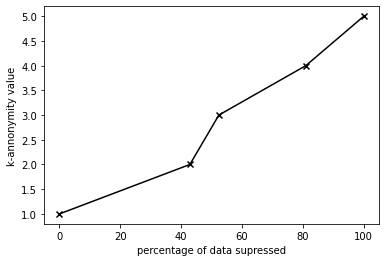

In [184]:
plt.plot(supressed_vals, k_vals, c='k')
plt.scatter(supressed_vals, k_vals, marker='x', c='k')
plt.xlabel("percentage of data supressed") 
plt.ylabel("k-annonymity value")


In [185]:
dfs = df.copy()
qid = ['ranged', 'Gender (QID)'] # define quasi-identifyer groups
k_vals = []
generalise_vals = np.arange(1, 40)

for step_size in generalise_vals:
    dfs['ranged'] = np.floor((dfs['Age (QID)'] / step_size))*step_size
    dfs['ranged'] = dfs['ranged'].astype(int)
    k_vals.append(k_annonymity(dfs, qid))


Text(0, 0.5, 'k-annonymity value')

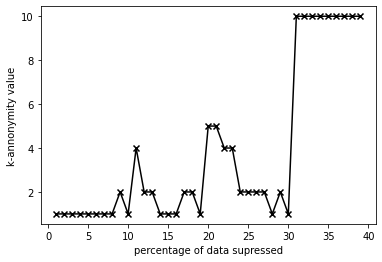

In [186]:
plt.plot(generalise_vals, k_vals, c='k')
plt.scatter(generalise_vals, k_vals, marker='x', c='k')
plt.xlabel("percentage of data supressed") 
plt.ylabel("k-annonymity value")
